In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import CHEATCP_fxns_V3 as cf
import os

In [2]:
BASE_DIR = r'C:\Users\LibraryUser\Downloads\Fall2024\BrainAndAction\CP\CP'
DATA_DIR = os.path.join(BASE_DIR, 'data')
RESULTS_DIR = os.path.join(BASE_DIR+r"\final_code", 'results_revised')
print(f"Results Directory: {RESULTS_DIR}")

MATFILES_DIR = os.path.join(DATA_DIR, 'matfiles')
MASTER_FILE = os.path.join(DATA_DIR, 'KINARMdataset_SubjectSummary_All Visits_OK_12-20-23.xlsx')
DEFAULTS = cf.define_defaults()
excel_output_path = os.path.join(RESULTS_DIR, 'Pvar_Values_BlockWise_revised.xlsx')


Results Directory: C:\Users\LibraryUser\Downloads\Fall2024\BrainAndAction\CP\CP\final_code\results_revised


In [3]:
mdf = pd.read_excel(open(MASTER_FILE, 'rb'), sheet_name='KINARM_AllVisitsMaster')
all_df , all_trajs = cf.getDataCP(mdf,MATFILES_DIR,DEFAULTS)

evaluating the subject : cpvib040
evaluated the kindData for sub : cpvib040
evaluating the subject : cpvib040
evaluated the kindData for sub : cpvib040
evaluating the subject : cpvib040
evaluated the kindData for sub : cpvib040
evaluating the subject : cpvib040
no peaks found
no peaks found
evaluated the kindData for sub : cpvib040
evaluating the subject : cpvib040
bad first peak
evaluated the kindData for sub : cpvib040


In [6]:
all_df.shape

(800, 39)

In [7]:
unique_days = all_df['day'].unique()
unique_days.sort()
unique_arms = all_df['Affected'].unique()
unique_durations = all_df['Duration'].unique()

In [ ]:
for day in unique_days:
    
    day_df = all_df[all_df['day'] == day]
    print(f'Day : { day } and # of trials are : {len(day_df)}')

    for arm in unique_arms:

        arm_trials = day_df[day_df['Affected'] == arm]
        print(f'on {day} and With arm as {arm} we have {len(arm_trials)} trials')

        for duration in unique_durations:

            duration_arm_df = arm_trials[arm_trials['Duration'] == duration]
            print(f'on {day} and with arm as {arm} we have {len(duration_arm_df)} trials and in duration : {duration}')

In [110]:
def time_normalize_trajectory(traj_x, traj_y, CT, num_points=500):
    
    if not np.isnan(CT):
        CT = int(CT)
        traj_x = traj_x[:CT]
        traj_y = traj_y[:CT]
      
    # Create a normalized time vector from 0 to 1
    original_time = np.linspace(0, 1, len(traj_x))
    normalized_time = np.linspace(0, 1, num_points)

    norm_x = np.interp(normalized_time, original_time, traj_x)
    norm_y = np.interp(normalized_time, original_time, traj_y)

    return norm_x, norm_y



def time_normalize_all_trials(unique_day_arm_df, num_points=500):
    normalized_x_list = []
    normalized_y_list = []

    for idx, row in unique_day_arm_df.iterrows():
        traj_x = row['x_hand_filt']
        traj_y = row['y_hand_filt']
        CT = row['CT'] 
        norm_x, norm_y = time_normalize_trajectory(traj_x, traj_y, CT, num_points)
        normalized_x_list.append(norm_x)
        normalized_y_list.append(norm_y)

    # Add the normalized x and y trajectories back to the DataFrame
    unique_day_arm_df['normalized_x'] = normalized_x_list
    unique_day_arm_df['normalized_y'] = normalized_y_list

    return unique_day_arm_df



In [106]:


def calculate_mean_trajectory(left_trials_df, right_trials_df):
    random_state=50
    left_trials_df = left_trials_df.dropna(subset=['CT'])
    right_trials_df = right_trials_df.dropna(subset=['CT'])
    print(f'After dropping na \n Num of records in left_trials : {len(left_trials_df)} and right_trials : {len(right_trials_df)}')

    min_trial_count = min(len(left_trials_df), len(right_trials_df))
    # if len(left_trials_df) > min_trial_count:
    #     left_trials_df = left_trials_df.nlargest(min_trial_count, 'CT')
    # elif len(right_trials_df) > min_trial_count:
    #     right_trials_df = right_trials_df.nlargest(min_trial_count, 'CT')

    if len(left_trials_df) > min_trial_count:
        left_trials_df = left_trials_df.sample(n=min_trial_count, random_state=random_state).reset_index(drop=True)
        print(f'Randomly sampled {len(left_trials_df)} left trials.')
    elif len(right_trials_df) > min_trial_count:
        right_trials_df = right_trials_df.sample(n=min_trial_count, random_state=random_state).reset_index(drop=True)
        print(f'Randomly sampled {len(right_trials_df)} right trials.')

    combined_trials_df = pd.concat([left_trials_df, right_trials_df], ignore_index=True)
    print(f'Total number of trials after balancing: {len(combined_trials_df)}')

    hand_x_list = []
    hand_y_list = []

    for idx, row in combined_trials_df.iterrows():

        hand_x = row['normalized_x']
        hand_y = row['normalized_y']
        CT = row['CT']
       
        hand_x_list.append(hand_x)
        hand_y_list.append(hand_y)

    hand_x_array = np.array(hand_x_list)  # Shape: (num_trials, num_points)
    hand_y_array = np.array(hand_y_list)
    
    mean_x = np.mean(hand_x_list,axis=0)
    mean_y = np.mean(hand_y_list,axis=0)

    deviation_x_array = hand_x_array - mean_x
    deviation_y_array = hand_y_array - mean_y

    # Calculate standard deviations at each time point
    std_x = np.std(deviation_x_array, axis=0)
    std_y = np.std(deviation_y_array, axis=0)

    Pvar_x = np.sum(std_x)
    Pvar_y = np.sum(std_y)
    
    return mean_x, mean_y, std_x, std_y, Pvar_x+Pvar_y


on Day1 and With arm as Less Affected we have 30 trials and condition is : Reaching
Num of records in left trials : 14 and right trials : 16
After dropping na 
 Num of records in left_trials: 14 and right_trials: 16
Randomly sampled 14 right trials.
Total number of trials after balancing: 28
Obtained Pvar_x : 12017.129927187687


C:\Users\LibraryUser\AppData\Local\Temp\ipykernel_9396\1934236980.py:172: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_day_arm_df['normalized_x'] = normalized_x_list
C:\Users\LibraryUser\AppData\Local\Temp\ipykernel_9396\1934236980.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_day_arm_df['normalized_y'] = normalized_y_list


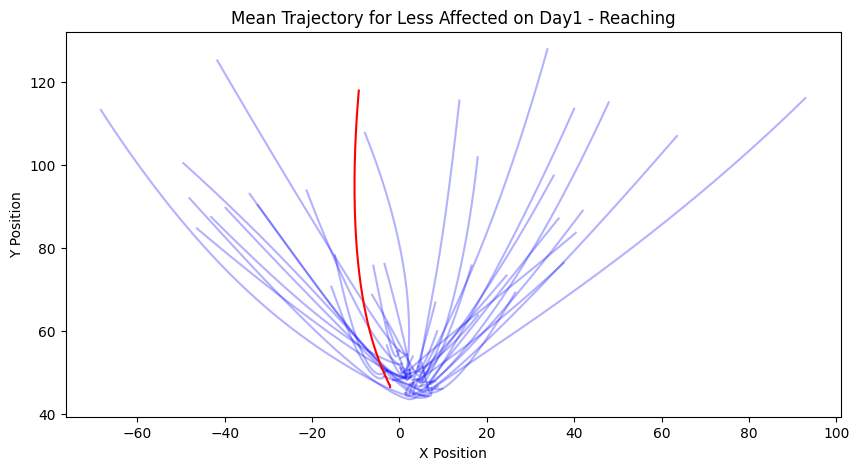

on Day1 and With arm as More Affected we have 40 trials and condition is : Reaching
Num of records in left trials : 20 and right trials : 20
After dropping na 
 Num of records in left_trials: 20 and right_trials: 20
Total number of trials after balancing: 40
Obtained Pvar_x : 8560.437560107075


C:\Users\LibraryUser\AppData\Local\Temp\ipykernel_9396\1934236980.py:172: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_day_arm_df['normalized_x'] = normalized_x_list
C:\Users\LibraryUser\AppData\Local\Temp\ipykernel_9396\1934236980.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_day_arm_df['normalized_y'] = normalized_y_list


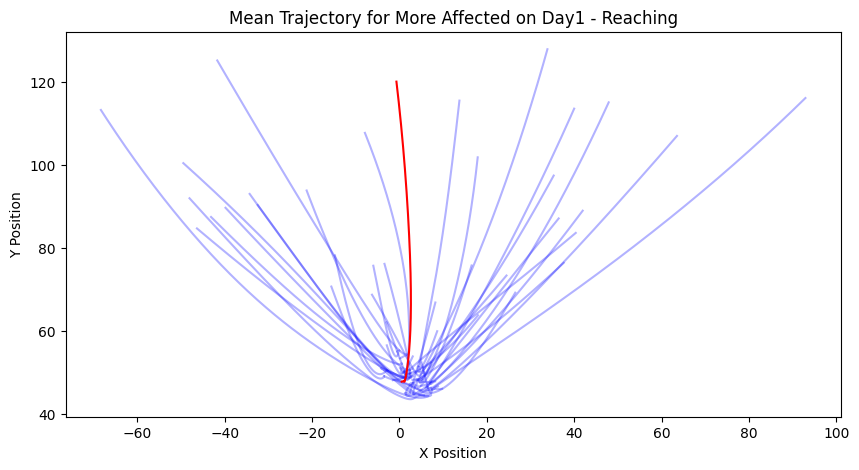

on Day1 and With arm as Less Affected we have 33 trials and condition is : Interception
Num of records in left trials : 17 and right trials : 16
After dropping na 
 Num of records in left_trials: 17 and right_trials: 16
Randomly sampled 16 left trials.
Total number of trials after balancing: 32
Obtained Pvar_x : 10552.784159833975


C:\Users\LibraryUser\AppData\Local\Temp\ipykernel_9396\1934236980.py:172: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_day_arm_df['normalized_x'] = normalized_x_list
C:\Users\LibraryUser\AppData\Local\Temp\ipykernel_9396\1934236980.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_day_arm_df['normalized_y'] = normalized_y_list


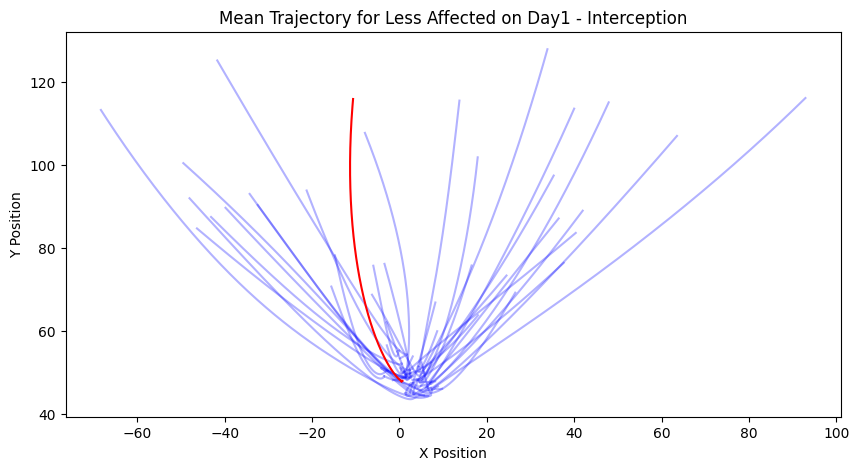

on Day1 and With arm as More Affected we have 39 trials and condition is : Interception
Num of records in left trials : 19 and right trials : 20
After dropping na 
 Num of records in left_trials: 19 and right_trials: 20
Randomly sampled 19 right trials.
Total number of trials after balancing: 38
Obtained Pvar_x : 11057.835156926949


C:\Users\LibraryUser\AppData\Local\Temp\ipykernel_9396\1934236980.py:172: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_day_arm_df['normalized_x'] = normalized_x_list
C:\Users\LibraryUser\AppData\Local\Temp\ipykernel_9396\1934236980.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_day_arm_df['normalized_y'] = normalized_y_list


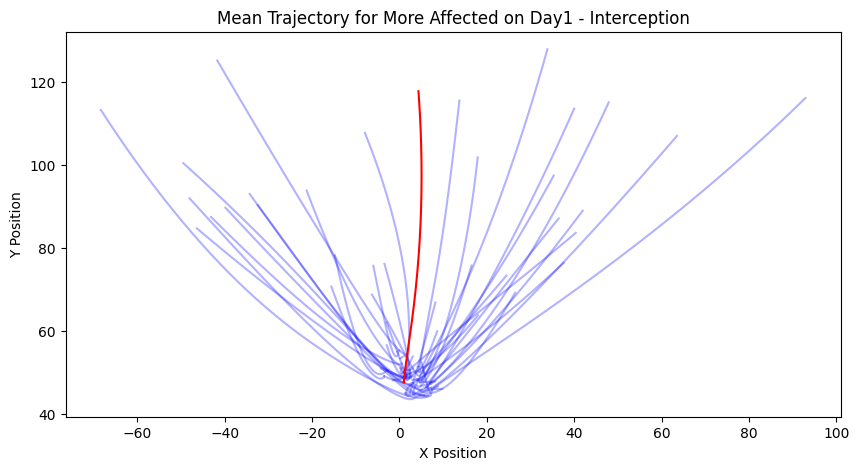

on Day2 and With arm as Less Affected we have 35 trials and condition is : Reaching
Num of records in left trials : 16 and right trials : 19
After dropping na 
 Num of records in left_trials: 16 and right_trials: 19
Randomly sampled 16 right trials.
Total number of trials after balancing: 32
Obtained Pvar_x : 9607.201355325109


C:\Users\LibraryUser\AppData\Local\Temp\ipykernel_9396\1934236980.py:172: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_day_arm_df['normalized_x'] = normalized_x_list
C:\Users\LibraryUser\AppData\Local\Temp\ipykernel_9396\1934236980.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_day_arm_df['normalized_y'] = normalized_y_list


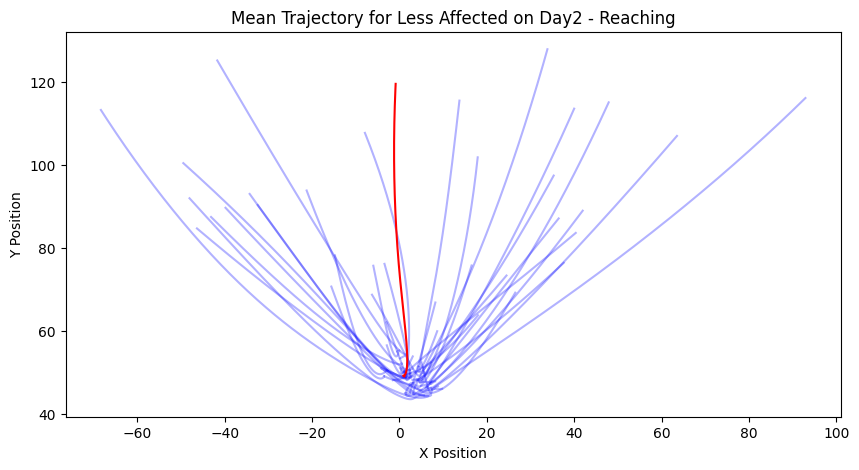

on Day2 and With arm as More Affected we have 38 trials and condition is : Reaching
Num of records in left trials : 19 and right trials : 19
After dropping na 
 Num of records in left_trials: 19 and right_trials: 19
Total number of trials after balancing: 38
Obtained Pvar_x : 10059.71831350094


C:\Users\LibraryUser\AppData\Local\Temp\ipykernel_9396\1934236980.py:172: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_day_arm_df['normalized_x'] = normalized_x_list
C:\Users\LibraryUser\AppData\Local\Temp\ipykernel_9396\1934236980.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_day_arm_df['normalized_y'] = normalized_y_list


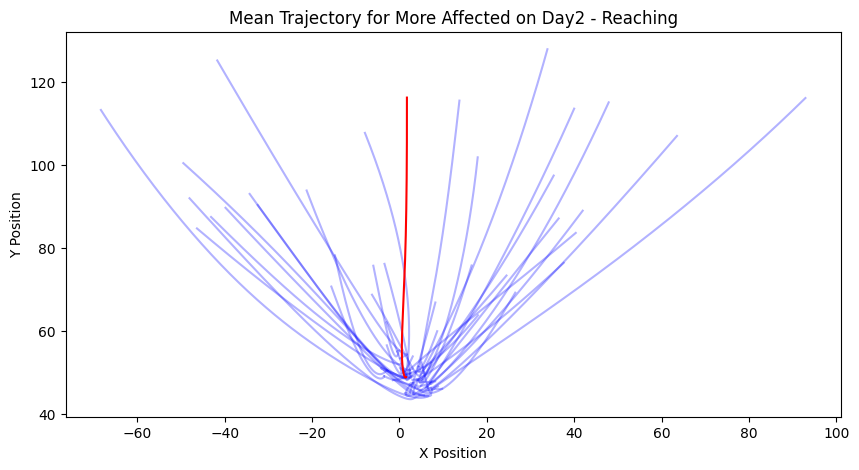

on Day2 and With arm as Less Affected we have 38 trials and condition is : Interception
Num of records in left trials : 20 and right trials : 18
After dropping na 
 Num of records in left_trials: 20 and right_trials: 18
Randomly sampled 18 left trials.
Total number of trials after balancing: 36
Obtained Pvar_x : 13564.551685861175


C:\Users\LibraryUser\AppData\Local\Temp\ipykernel_9396\1934236980.py:172: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_day_arm_df['normalized_x'] = normalized_x_list
C:\Users\LibraryUser\AppData\Local\Temp\ipykernel_9396\1934236980.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_day_arm_df['normalized_y'] = normalized_y_list


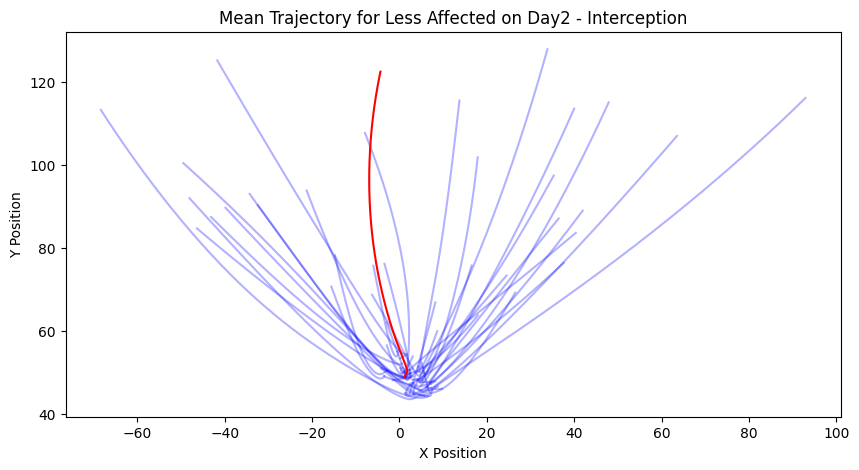

on Day2 and With arm as More Affected we have 32 trials and condition is : Interception
Num of records in left trials : 14 and right trials : 18
After dropping na 
 Num of records in left_trials: 14 and right_trials: 18
Randomly sampled 14 right trials.
Total number of trials after balancing: 28
Obtained Pvar_x : 15396.636571190867


C:\Users\LibraryUser\AppData\Local\Temp\ipykernel_9396\1934236980.py:172: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_day_arm_df['normalized_x'] = normalized_x_list
C:\Users\LibraryUser\AppData\Local\Temp\ipykernel_9396\1934236980.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_day_arm_df['normalized_y'] = normalized_y_list


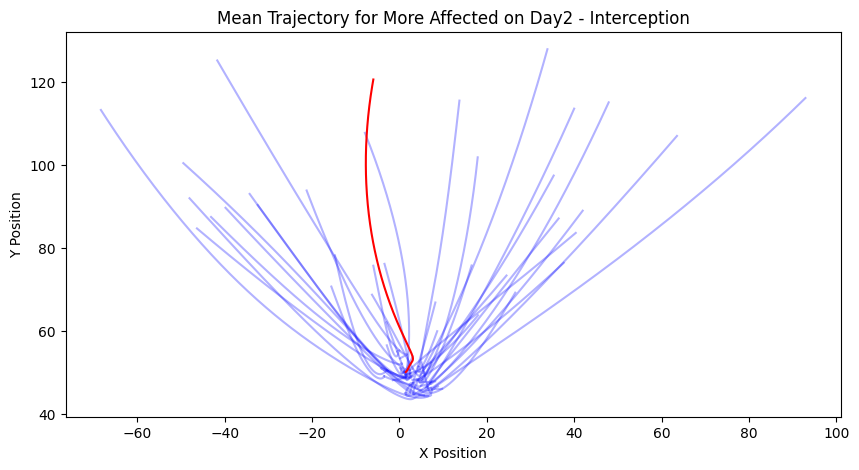

on Day3 and With arm as Less Affected we have 40 trials and condition is : Reaching
Num of records in left trials : 20 and right trials : 20
After dropping na 
 Num of records in left_trials: 20 and right_trials: 20
Total number of trials after balancing: 40
Obtained Pvar_x : 7699.975150664943


C:\Users\LibraryUser\AppData\Local\Temp\ipykernel_9396\1934236980.py:172: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_day_arm_df['normalized_x'] = normalized_x_list
C:\Users\LibraryUser\AppData\Local\Temp\ipykernel_9396\1934236980.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_day_arm_df['normalized_y'] = normalized_y_list


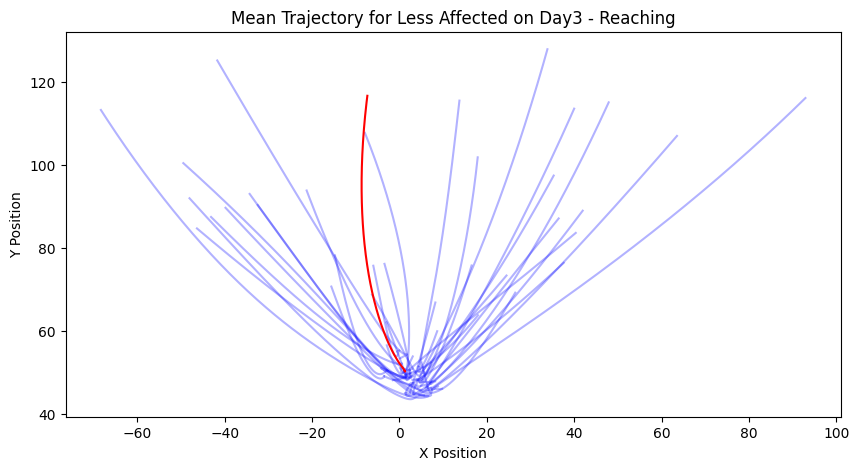

on Day3 and With arm as More Affected we have 36 trials and condition is : Reaching
Num of records in left trials : 17 and right trials : 19
After dropping na 
 Num of records in left_trials: 17 and right_trials: 19
Randomly sampled 17 right trials.
Total number of trials after balancing: 34
Obtained Pvar_x : 9952.117889480553


C:\Users\LibraryUser\AppData\Local\Temp\ipykernel_9396\1934236980.py:172: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_day_arm_df['normalized_x'] = normalized_x_list
C:\Users\LibraryUser\AppData\Local\Temp\ipykernel_9396\1934236980.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_day_arm_df['normalized_y'] = normalized_y_list


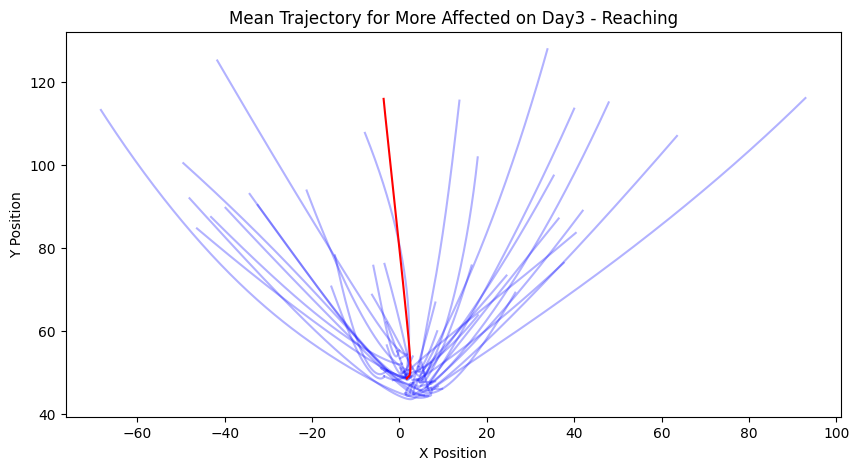

on Day3 and With arm as Less Affected we have 33 trials and condition is : Interception
Num of records in left trials : 16 and right trials : 17
After dropping na 
 Num of records in left_trials: 16 and right_trials: 17
Randomly sampled 16 right trials.
Total number of trials after balancing: 32
Obtained Pvar_x : 13157.743101359656


C:\Users\LibraryUser\AppData\Local\Temp\ipykernel_9396\1934236980.py:172: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_day_arm_df['normalized_x'] = normalized_x_list
C:\Users\LibraryUser\AppData\Local\Temp\ipykernel_9396\1934236980.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_day_arm_df['normalized_y'] = normalized_y_list


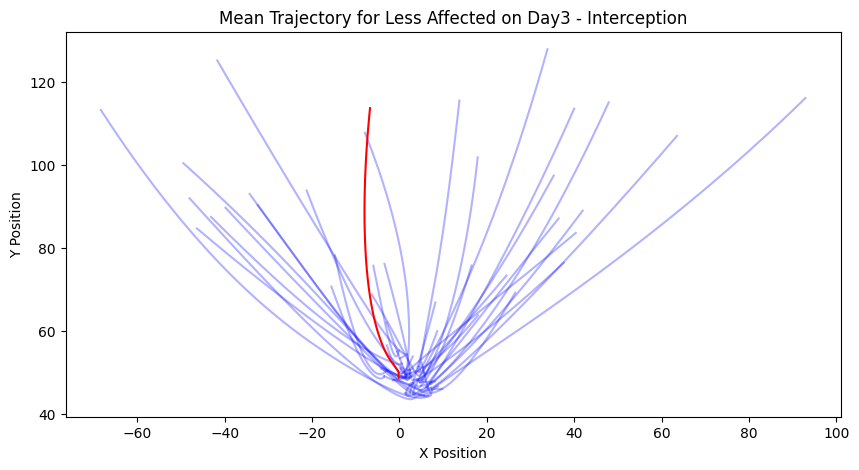

on Day3 and With arm as More Affected we have 37 trials and condition is : Interception
Num of records in left trials : 19 and right trials : 18
After dropping na 
 Num of records in left_trials: 19 and right_trials: 18
Randomly sampled 18 left trials.
Total number of trials after balancing: 36
Obtained Pvar_x : 11172.900684529232


C:\Users\LibraryUser\AppData\Local\Temp\ipykernel_9396\1934236980.py:172: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_day_arm_df['normalized_x'] = normalized_x_list
C:\Users\LibraryUser\AppData\Local\Temp\ipykernel_9396\1934236980.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_day_arm_df['normalized_y'] = normalized_y_list


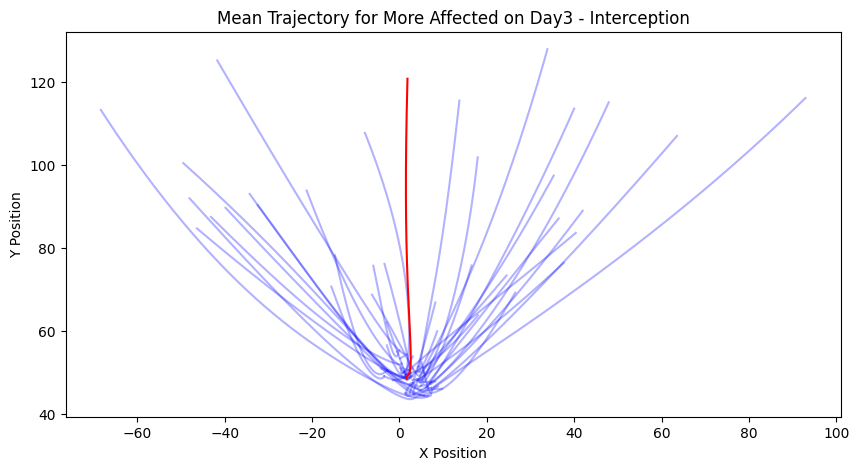

on Day4 and With arm as Less Affected we have 33 trials and condition is : Reaching


C:\Users\LibraryUser\AppData\Local\Temp\ipykernel_9396\1934236980.py:172: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_day_arm_df['normalized_x'] = normalized_x_list
C:\Users\LibraryUser\AppData\Local\Temp\ipykernel_9396\1934236980.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_day_arm_df['normalized_y'] = normalized_y_list


Num of records in left trials : 17 and right trials : 16
After dropping na 
 Num of records in left_trials: 17 and right_trials: 16
Randomly sampled 16 left trials.
Total number of trials after balancing: 32
Obtained Pvar_x : 7944.882124369229


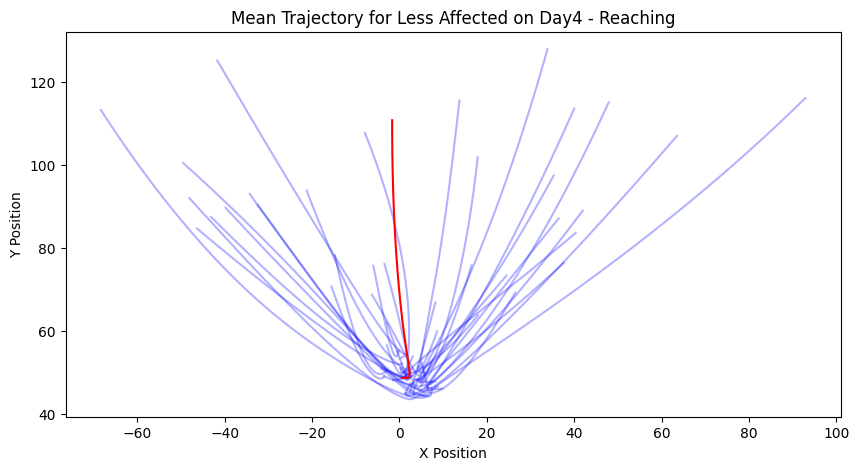

on Day4 and With arm as More Affected we have 35 trials and condition is : Reaching
Num of records in left trials : 16 and right trials : 19
After dropping na 
 Num of records in left_trials: 16 and right_trials: 19
Randomly sampled 16 right trials.
Total number of trials after balancing: 32
Obtained Pvar_x : 7074.0796284877815


C:\Users\LibraryUser\AppData\Local\Temp\ipykernel_9396\1934236980.py:172: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_day_arm_df['normalized_x'] = normalized_x_list
C:\Users\LibraryUser\AppData\Local\Temp\ipykernel_9396\1934236980.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_day_arm_df['normalized_y'] = normalized_y_list


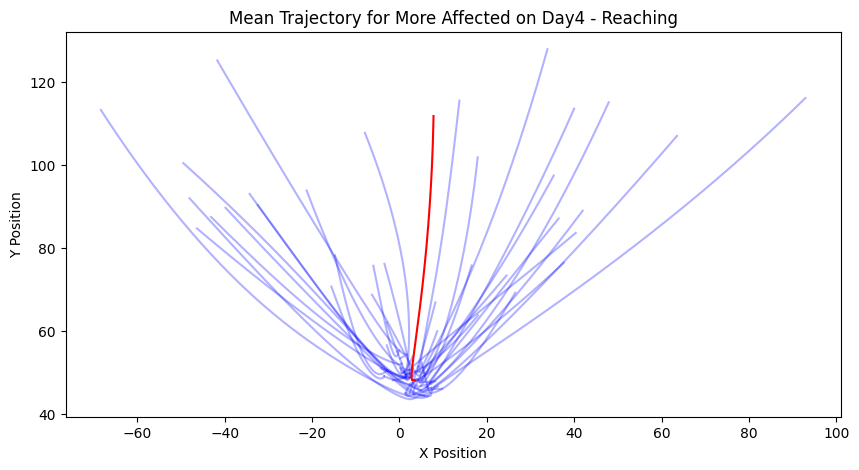

on Day4 and With arm as Less Affected we have 36 trials and condition is : Interception
Num of records in left trials : 20 and right trials : 16
After dropping na 
 Num of records in left_trials: 20 and right_trials: 16
Randomly sampled 16 left trials.
Total number of trials after balancing: 32
Obtained Pvar_x : 9245.541927459608


C:\Users\LibraryUser\AppData\Local\Temp\ipykernel_9396\1934236980.py:172: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_day_arm_df['normalized_x'] = normalized_x_list
C:\Users\LibraryUser\AppData\Local\Temp\ipykernel_9396\1934236980.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_day_arm_df['normalized_y'] = normalized_y_list


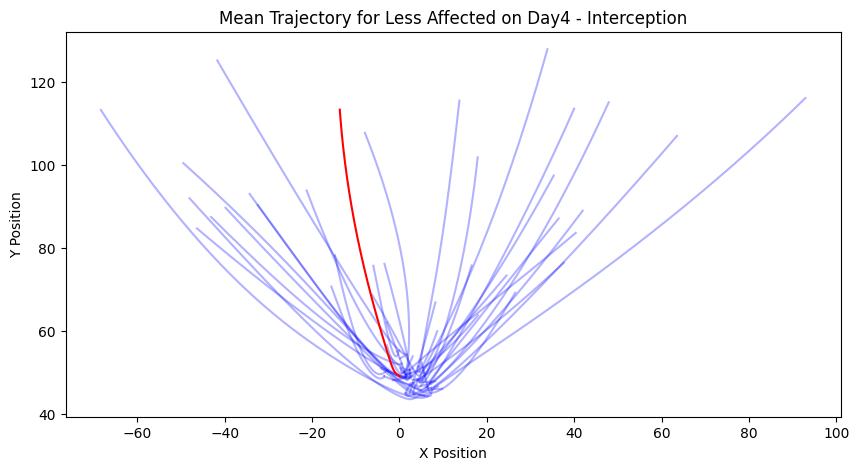

on Day4 and With arm as More Affected we have 36 trials and condition is : Interception
Num of records in left trials : 16 and right trials : 20
After dropping na 
 Num of records in left_trials: 16 and right_trials: 20
Randomly sampled 16 right trials.
Total number of trials after balancing: 32
Obtained Pvar_x : 8596.343234005377


C:\Users\LibraryUser\AppData\Local\Temp\ipykernel_9396\1934236980.py:172: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_day_arm_df['normalized_x'] = normalized_x_list
C:\Users\LibraryUser\AppData\Local\Temp\ipykernel_9396\1934236980.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_day_arm_df['normalized_y'] = normalized_y_list


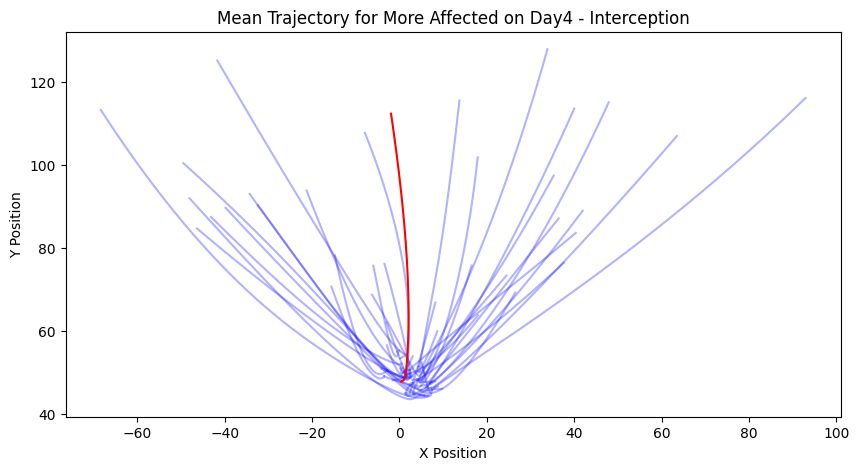

on Day5 and With arm as Less Affected we have 36 trials and condition is : Reaching
Num of records in left trials : 18 and right trials : 18
After dropping na 
 Num of records in left_trials: 18 and right_trials: 18
Total number of trials after balancing: 36
Obtained Pvar_x : 8362.33968590903


C:\Users\LibraryUser\AppData\Local\Temp\ipykernel_9396\1934236980.py:172: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_day_arm_df['normalized_x'] = normalized_x_list
C:\Users\LibraryUser\AppData\Local\Temp\ipykernel_9396\1934236980.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_day_arm_df['normalized_y'] = normalized_y_list


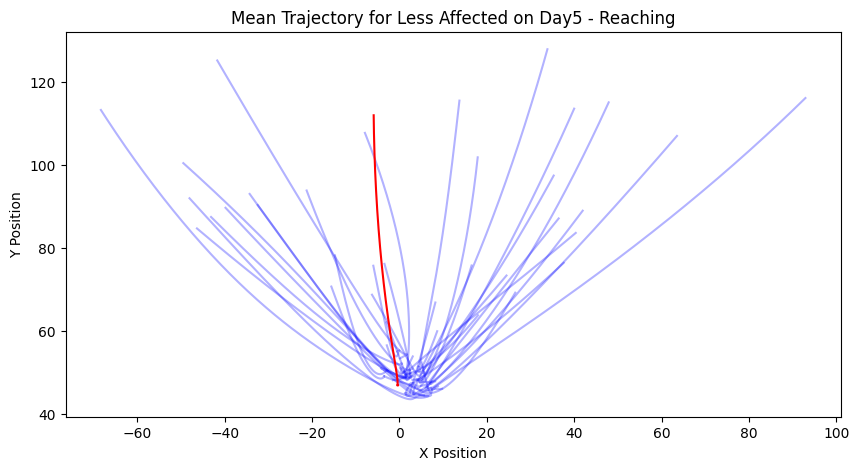

on Day5 and With arm as More Affected we have 40 trials and condition is : Reaching
Num of records in left trials : 20 and right trials : 20
After dropping na 
 Num of records in left_trials: 20 and right_trials: 20
Total number of trials after balancing: 40
Obtained Pvar_x : 7263.015110616784


C:\Users\LibraryUser\AppData\Local\Temp\ipykernel_9396\1934236980.py:172: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_day_arm_df['normalized_x'] = normalized_x_list
C:\Users\LibraryUser\AppData\Local\Temp\ipykernel_9396\1934236980.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_day_arm_df['normalized_y'] = normalized_y_list


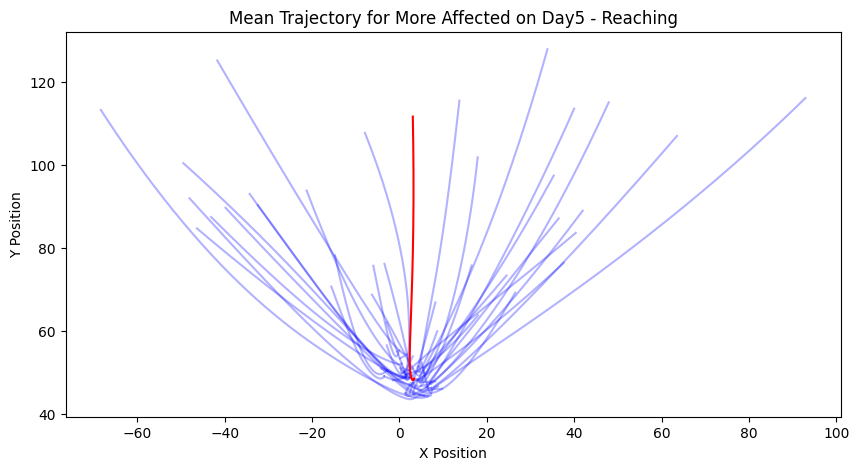

on Day5 and With arm as Less Affected we have 34 trials and condition is : Interception
Num of records in left trials : 15 and right trials : 19
After dropping na 
 Num of records in left_trials: 15 and right_trials: 19
Randomly sampled 15 right trials.
Total number of trials after balancing: 30
Obtained Pvar_x : 10932.074102044751


C:\Users\LibraryUser\AppData\Local\Temp\ipykernel_9396\1934236980.py:172: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_day_arm_df['normalized_x'] = normalized_x_list
C:\Users\LibraryUser\AppData\Local\Temp\ipykernel_9396\1934236980.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_day_arm_df['normalized_y'] = normalized_y_list


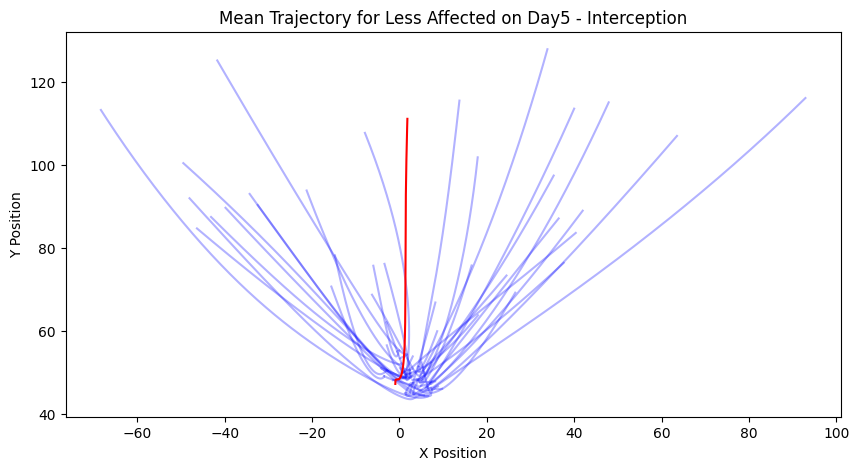

on Day5 and With arm as More Affected we have 40 trials and condition is : Interception
Num of records in left trials : 20 and right trials : 20
After dropping na 
 Num of records in left_trials: 20 and right_trials: 20
Total number of trials after balancing: 40
Obtained Pvar_x : 10712.058706019057


C:\Users\LibraryUser\AppData\Local\Temp\ipykernel_9396\1934236980.py:172: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_day_arm_df['normalized_x'] = normalized_x_list
C:\Users\LibraryUser\AppData\Local\Temp\ipykernel_9396\1934236980.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_day_arm_df['normalized_y'] = normalized_y_list


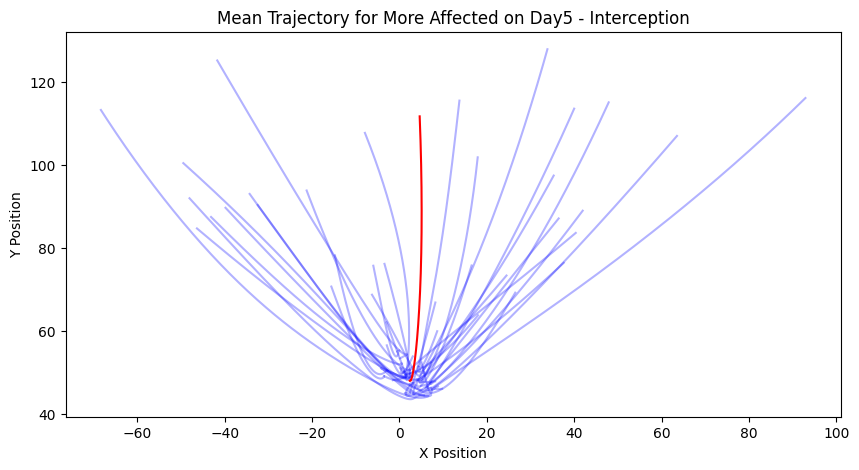

In [130]:
pvar_results = []
for day in unique_days:
  
    day_df = all_df[(all_df['day'] == day)]
   
    condition = day_df['Condition'].unique()
    
    subject = 'cpvib040'
    dict_key = f'{subject}{day}'
    traj_list = all_trajs[dict_key]
    x_target_end_values = [entry['xTargetPos'] for entry in traj_list[0:]]
    x_target_end_list = [array[-1] for array in x_target_end_values]
    x_hand_filt = [entry['HandX_filt'] for entry in traj_list[0:]]
    y_hand_filt = [entry['HandY_filt'] for entry in traj_list[0:]]
    
    # Add x_target_end_list as a column to day_df
    day_df = day_df.copy()
    day_df['xTargetEndPos'] = x_target_end_list
    day_df['x_hand_filt'] = x_hand_filt
    day_df['y_hand_filt'] = y_hand_filt
    
    if len(day_df) != len(traj_list):
        print(f'Mismatch in the # of trials and the day_df data for dict_key : {dict_key}')
        continue

    for condition in conditions:
        for arm in unique_arms:
            normalized_x = []
            normalized_y = []
            
            unique_day_arm_condition_df = day_df[(day_df['Affected'] == arm) & (day_df['Condition'] == condition) & (~day_df['CT'].isna())] #check if removing this CT is really req.
            arm_trials = unique_day_arm_condition_df.shape[0]
            print(f'on {day} and With arm as {arm} we have {arm_trials} trials and condition is : {condition}')
            unique_day_arm_df.to_csv(f'arm_trials_{day}_{arm}.csv')
            
            # group_columns = ['Affected', 'Duration', 'Condition']
            # groups = unique_day_arm_df.groupby(group_columns)
           
            unique_day_arm_condition_df = time_normalize_all_trials(unique_day_arm_condition_df, num_points=600)
            
            left_trials_df = unique_day_arm_condition_df[unique_day_arm_condition_df['xTargetEndPos'] < 0]
            right_trials_df = unique_day_arm_condition_df[unique_day_arm_condition_df['xTargetEndPos'] > 0]
            print(f'Num of records in left trials : {len(left_trials_df)} and right trials : {len(right_trials_df)}')
            
            mean_x, mean_y, std_x, std_y, Pvar = calculate_mean_trajectory(left_trials_df,right_trials_df)
            print(f'Obtained Pvar_x : {Pvar}')
            
            pvar_results.append({
                'Subject': subject,
                'Day': day,
                'Condition': condition,
                'Arm': arm,
                'Pvar': Pvar,
                'mean_x': mean_x.tolist(),  # Convert numpy arrays to lists for CSV compatibility
                'mean_y': mean_y.tolist(),
                'std_x': std_x.tolist(),
                'std_y': std_y.tolist()
            })

            # Plot standard deviations over time
            plt.figure(figsize=(10, 5))
         
    
            for itr, row in unique_day_arm_df.iterrows():
                HandX_Filt = row['normalized_x']
                HandY_Filt = row['normalized_y']
                if not np.isnan(row['CT']):
                    CT = int(row['CT'])
                    plt.plot(HandX_Filt[0:CT], HandY_Filt[0:CT], label='Participant Path', color='blue', alpha=0.3)
                else:
                    plt.plot(HandX_Filt, HandY_Filt, label='Participant Path', color='blue', alpha=0.3) #check with Dr.Barany if I shall plot these or not, this plots the complete handpath where CT is missing
            plt.plot(mean_x, mean_y, label='Mean Trajectory', color='red')
            plt.title(f'Mean Trajectory for {arm} on {day} - {condition}')
            plt.xlabel('X Position')
            plt.ylabel('Y Position')
            plt.show()
            

In [132]:
pvar_df = pd.DataFrame(pvar_results)
if pvar_df.empty:
    print("No Pvar results were computed. Please check your data and processing steps.")
    exit(1)
pvar_df['Block'] = pvar_df.apply(lambda row: f"{row['Condition']}_{row['Arm']}", axis=1)

pivot_df = pvar_df.pivot_table(index=['Subject', 'Day'], columns='Block', values='Pvar')
pivot_df = pivot_df.reset_index()
pivot_df.columns.name = None  # Remove the aggregation name
pivot_df.columns = ['Subject', 'Day'] + list(pivot_df.columns[2:])

try:
    pivot_df.to_excel(excel_output_path, index=False, engine='openpyxl')
    print(f"Pvar values successfully saved to {excel_output_path}")
except Exception as e:
    print(f"An error occurred while saving to Excel: {e}")
    exit(1)


Pvar values successfully saved to C:\Users\LibraryUser\Downloads\Fall2024\BrainAndAction\CP\CP\final_code\results_revised\Pvar_Values_BlockWise_revised.xlsx


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Initialize results list
pvar_results = []

for day in unique_days:
    day_df = all_df[all_df['day'] == day].copy()
    subject = 'cpvib040'
    dict_key = f'{subject}{day}'
    traj_list = all_trajs.get(dict_key, [])
    
    if not traj_list:
        print(f'No trajectory data found for dict_key: {dict_key}')
        continue
    
    x_target_end_values = [entry['xTargetPos'] for entry in traj_list]
    x_target_end_list = [array[-1] if len(array) > 0 else np.nan for array in x_target_end_values]
    x_hand_filt = [entry['HandX_filt'] for entry in traj_list]
    y_hand_filt = [entry['HandY_filt'] for entry in traj_list]
    
    # Add computed columns to day_df
    day_df['xTargetEndPos'] = x_target_end_list
    day_df['x_hand_filt'] = x_hand_filt
    day_df['y_hand_filt'] = y_hand_filt
    
    # Check for trial count consistency
    if len(day_df) != len(traj_list):
        print(f'Mismatch in the # of trials and the day_df data for dict_key: {dict_key}')
        continue
    
    for arm in unique_arms:
        unique_day_arm_df = day_df[
            (day_df['Affected'] == arm) &
            (day_df['Condition'] == 'Reaching') &
            (~day_df['CT'].isna())  
        ]
        
        arm_trials = unique_day_arm_df.shape[0]
        print(f'on {day} and With arm as {arm} we have {arm_trials} trials and condition is: Reaching')
        
        # Optionally save filtered trials
        unique_day_arm_df.to_csv(f'arm_trials_{day}_{arm}.csv', index=False)
        
        group_columns = ['Affected', 'Duration', 'Condition']
        groups = unique_day_arm_df.groupby(group_columns)
       
        # Normalize all trials
        unique_day_arm_df = time_normalize_all_trials(unique_day_arm_df, num_points=600)
        
        # Separate left and right trials based on target end position
        left_trials_df = unique_day_arm_df[unique_day_arm_df['xTargetEndPos'] < 0]
        right_trials_df = unique_day_arm_df[unique_day_arm_df['xTargetEndPos'] > 0]
        print(f'Num of records in left trials: {len(left_trials_df)} and right trials: {len(right_trials_df)}')
        
        # Calculate mean trajectory and Pvar
        mean_x, mean_y, std_x, std_y, Pvar = calculate_mean_trajectory(left_trials_df, right_trials_df)
        print(f'Obtained Pvar_x + Pvar_y: {Pvar}')
        
        # Append results, now there is no duration - previously we divided it across TP
        pvar_results.append({
            'Subject': subject,
            'Day': day,
            'Condition': 'Reaching',
            'Arm': arm,
            'Pvar': Pvar,
            'mean_x' : mean_x,
            'mean_y' : mean_y,
            'std_x' : std_x,
            'std_y' : std_y
        })
        
        # Plot trajectories
        plt.figure(figsize=(10, 5))
        for _, row in unique_day_arm_df.iterrows():
            HandX_Filt = row['normalized_x']
            HandY_Filt = row['normalized_y']
            CT = row['CT']
            
            if not np.isnan(CT):
                CT = int(CT)
                plt.plot(HandX_Filt[:CT], HandY_Filt[:CT], color='blue', alpha=0.3)
            else:
                print('here')
                plt.plot(HandX_Filt, HandY_Filt, color='blue', alpha=0.3)  #check this part with Dr.Barany, this plots the whole hand path for the trials where CT is NA
        
        plt.plot(mean_x, mean_y, label='Mean Trajectory', color='red')
        plt.title(f'Mean Trajectory for {arm} on {day}')
        plt.xlabel('X Position')
        plt.ylabel('Y Position')
        plt.legend()
        plt.show()

def calculate_mean_trajectory(left_trials_df, right_trials_df):
    random_state = 50
    left_trials_df = left_trials_df.dropna(subset=['CT'])
    right_trials_df = right_trials_df.dropna(subset=['CT'])
    print(f'After dropping na \n Num of records in left_trials: {len(left_trials_df)} and right_trials: {len(right_trials_df)}')

    min_trial_count = min(len(left_trials_df), len(right_trials_df))

    if len(left_trials_df) > min_trial_count:
        left_trials_df = left_trials_df.sample(n=min_trial_count, random_state=random_state).reset_index(drop=True)
        print(f'Randomly sampled {len(left_trials_df)} left trials.')
    elif len(right_trials_df) > min_trial_count:
        right_trials_df = right_trials_df.sample(n=min_trial_count, random_state=random_state).reset_index(drop=True)
        print(f'Randomly sampled {len(right_trials_df)} right trials.')

    combined_trials_df = pd.concat([left_trials_df, right_trials_df], ignore_index=True)
    print(f'Total number of trials after balancing: {len(combined_trials_df)}')

    hand_x_list = combined_trials_df['normalized_x'].tolist()
    hand_y_list = combined_trials_df['normalized_y'].tolist()

    # Convert lists to numpy arrays
    hand_x_array = np.array(hand_x_list)  # Shape: (num_trials, num_points)
    hand_y_array = np.array(hand_y_list)
    
    # Compute mean trajectories
    mean_x = np.mean(hand_x_array, axis=0)
    mean_y = np.mean(hand_y_array, axis=0)

    # Compute deviations
    deviation_x_array = hand_x_array - mean_x
    deviation_y_array = hand_y_array - mean_y

    # Calculate standard deviations at each time point
    std_x = np.std(deviation_x_array, axis=0)
    std_y = np.std(deviation_y_array, axis=0)

    # Compute Pvar as the sum of standard deviations across all time points
    Pvar_x = np.sum(std_x)
    Pvar_y = np.sum(std_y)
    
    return mean_x, mean_y, std_x, std_y, Pvar_x + Pvar_y

def time_normalize_trajectory(traj_x, traj_y, CT, num_points=600):
    if not np.isnan(CT):
        CT = int(CT)
        traj_x = traj_x[:CT]
        traj_y = traj_y[:CT]
    
    # Create a normalized time vector from 0 to 1
    original_time = np.linspace(0, 1, len(traj_x))
    normalized_time = np.linspace(0, 1, num_points)

    # Handle potential issues with interpolation
    if len(traj_x) < 2:
        # Not enough points to interpolate, pad with last value
        norm_x = np.full(num_points, traj_x[0] if len(traj_x) > 0 else np.nan)
        norm_y = np.full(num_points, traj_y[0] if len(traj_y) > 0 else np.nan)
    else:
        norm_x = np.interp(normalized_time, original_time, traj_x)
        norm_y = np.interp(normalized_time, original_time, traj_y)

    return norm_x, norm_y

def time_normalize_all_trials(unique_day_arm_df, num_points=600):
    normalized_x_list = []
    normalized_y_list = []

    for _, row in unique_day_arm_df.iterrows():
        traj_x = row['x_hand_filt']
        traj_y = row['y_hand_filt']
        CT = row['CT'] 
        norm_x, norm_y = time_normalize_trajectory(traj_x, traj_y, CT, num_points)
        normalized_x_list.append(norm_x)
        normalized_y_list.append(norm_y)

    # Add the normalized x and y trajectories back to the DataFrame
    unique_day_arm_df['normalized_x'] = normalized_x_list
    unique_day_arm_df['normalized_y'] = normalized_y_list

    return unique_day_arm_df


In [127]:
pvar_df = pd.DataFrame(pvar_results)
# print(pvar_results)
if pvar_df.empty:
    print("No Pvar results were computed. Please check your data and processing steps.")
    exit(1)
pvar_df['Block'] = pvar_df.apply(lambda row: f"{row['Condition']}_{row['Arm']}", axis=1)

pivot_df = pvar_df.pivot_table(index=['Subject', 'Day'], columns='Block', values='Pvar')
pivot_df = pivot_df.reset_index()
pivot_df.columns.name = None  # Remove the aggregation name
pivot_df.columns = ['Subject', 'Day'] + list(pivot_df.columns[2:])

try:
    pivot_df.to_excel(excel_output_path, index=False, engine='openpyxl')
    print(f"Pvar values successfully saved to {excel_output_path}")
except Exception as e:
    print(f"An error occurred while saving to Excel: {e}")
    exit(1)


An error occurred while saving to Excel: [Errno 13] Permission denied: 'C:\\Users\\LibraryUser\\Downloads\\Fall2024\\BrainAndAction\\CP\\CP\\final_code\\results_revised\\Pvar_Values_BlockWise_revised.xlsx'


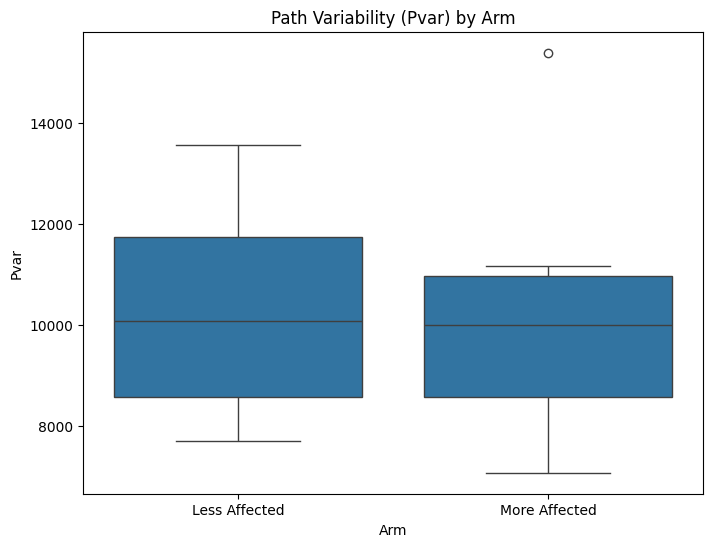

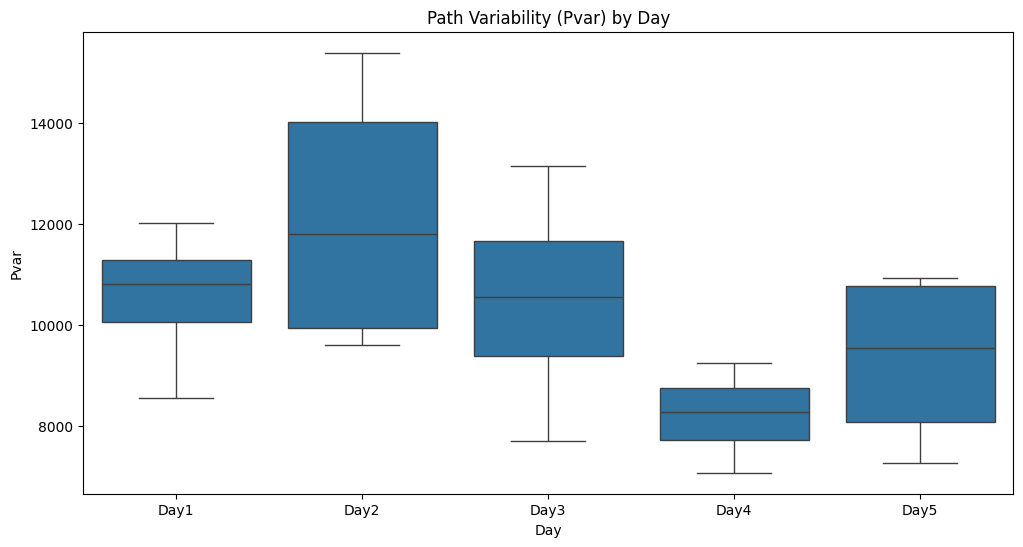

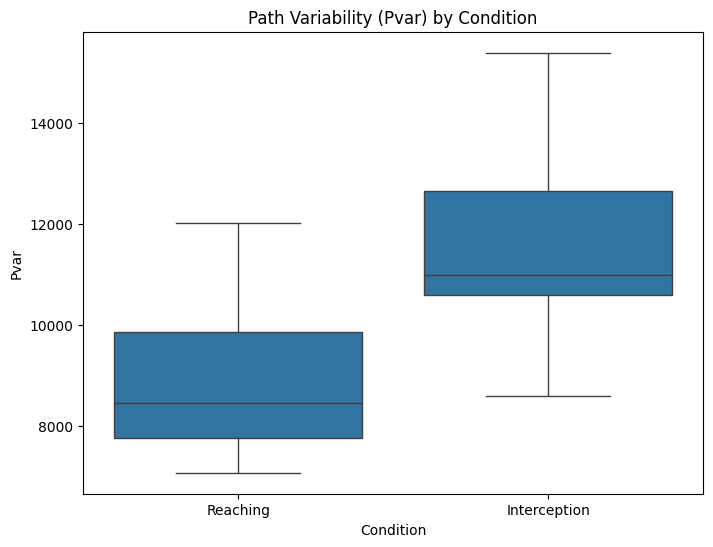

In [133]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming pvar_results is a list of dictionaries as per your code
pvar_df = pd.DataFrame(pvar_results)

# Boxplot of Pvar by Arm
plt.figure(figsize=(8, 6))
sns.boxplot(x='Arm', y='Pvar', data=pvar_df)
plt.title('Path Variability (Pvar) by Arm')
plt.xlabel('Arm')
plt.ylabel('Pvar')
plt.show()

# Boxplot of Pvar by Day
plt.figure(figsize=(12, 6))
sns.boxplot(x='Day', y='Pvar', data=pvar_df)
plt.title('Path Variability (Pvar) by Day')
plt.xlabel('Day')
plt.ylabel('Pvar')
plt.show()

# Boxplot of Pvar by Condition (if multiple conditions)
plt.figure(figsize=(8, 6))
sns.boxplot(x='Condition', y='Pvar', data=pvar_df)
plt.title('Path Variability (Pvar) by Condition')
plt.xlabel('Condition')
plt.ylabel('Pvar')
plt.show()


In [ ]:
import numpy as np

# Example function to plot mean trajectory with variability
def plot_trajectory_with_variability(mean_x, mean_y, std_x, std_y, arm, day):
    plt.figure(figsize=(10, 6))
    
    # Plot individual trajectories
    for _, row in unique_day_arm_df.iterrows():
        HandX_Filt = row['normalized_x']
        HandY_Filt = row['normalized_y']
        CT = row['CT']
        
        if not np.isnan(CT):
            CT = int(CT)
            plt.plot(HandX_Filt[:CT], HandY_Filt[:CT], color='blue', alpha=0.3)
        else:
            plt.plot(HandX_Filt, HandY_Filt, color='blue', alpha=0.3)
    T
    # Plot mean trajectory
    plt.plot(mean_x, mean_y, label='Mean Trajectory', color='red', linewidth=2)
    
    # Plot variability as shaded area
    plt.fill_between(mean_x, mean_y - std_y, mean_y + std_y, color='gray', alpha=0.2, label='Variability (±1 SD)')
    
    plt.title(f'Mean Trajectory with Variability for {arm} on {day}')
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.legend()
    plt.show()

# Example usage within your loop
for entry in pvar_results:
    mean_x = entry['mean_x']  # Ensure these are stored or accessible
    mean_y = entry['mean_y']
    std_x = entry['std_x']
    std_y = entry['std_y']
    arm = entry['Arm']
    day = entry['Day']
    
    plot_trajectory_with_variability(mean_x, mean_y, std_x, std_y, arm, day)
